In [1]:
#pip install ee

In [2]:
#pip install geemap

# Import Libraries

In [3]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO

#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [4]:
# DOC DATA 
data_doc = pd.read_excel('LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L','SITE_ID', 'DATE_SMP'])

# Read the "Site Information" Excel sheet to get the mapping between lake names and SITE_ID
site_info_df = pd.read_excel('Site_Information_2022_8_1 (2).xlsx', usecols=['SITE_ID', 'PROGRAM_ID', 'LAKE_DEPTH_MEAN', 'SITE_NAME'])


# PROF. Coordinates 
data_path = 'ALTM-50-stations.xlsx'
df_lake_info = pd.read_excel(data_path, sheet_name='updated station coordinates', usecols=['SITE_ID', 'SITE_NAME','LATDD_CENT', 'LONDD_CENT'])


merge_data = pd.merge(data_doc, site_info_df, on='SITE_ID')
merge_data = pd.merge(merge_data, df_lake_info, on= ['SITE_ID', 'SITE_NAME'])

data_modify = merge_data[merge_data['PROGRAM_ID']=='LTM_ALTM']

In [5]:
data_modify

,SITE_ID,DATE_SMP,DOC_MG_L,PROGRAM_ID,SITE_NAME,LAKE_DEPTH_MEAN,LATDD_CENT,LONDD_CENT
0,040850,1997-09-22,3.100000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
2,040850,1995-03-02,3.031000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
4,040850,1996-08-19,3.595000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
6,040850,2003-11-06,4.232000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
8,040850,2005-07-11,3.344000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
...,...,...,...,...,...,...,...,...
17863,1A3-048,2011-05-18,4.283944,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17864,1A3-048,2015-06-10,5.509394,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17865,1A3-048,2016-07-14,4.884900,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17866,1A3-048,2016-09-15,6.344000,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172


# REFLECTANCE data prep

In [6]:
sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

In [7]:
import ee
import geemap
import pandas as pd

# Authenticate and initialize the Earth Engine API
#ee.Authenticate()  # Only needed for the first time
ee.Initialize()

# Create a list of lake names
lake_names = [
    'Little Hope Pond', 'Big Hope Pond', 'East Copperas Pond', 'Sunday Pond', 'Sochia Pond',
    'Grass Pond (3)', 'Little Clear Pond', 'Loon Hollow Pond', 'Willys Lake', 'Woods Lake',
    'Middle Settlement Lake', 'Middle Branch Lake', 'Limekiln Lake', 'Squaw Lake', 'Indian Lake',
    'Brook Trout Lake', 'Lost Pond', 'North Lake', 'Willis Lake', 'Long Pond', 'Carry Pond',
    'Lake Colden', 'Avalanche Lake', 'Little Simon Pond', 'Raquette Lake Reservoir', 'G Lake',
    'Constable Pond', 'Middle Pond', 'Arbutus Pond', 'Sagamore Lake', 'Black Pond', 'Windfall Pond',
    'Queer Lake', 'Heart Lake', 'Big Moose Lake', 'Cascade Lake', 'Dart Lake', 'Little Echo Pond',
    'Moss Lake', 'Lake Rondaxe', 'Squash Pond', 'West Pond', 'Owen Pond', 'Jockeybush Lake',
    'Barnes Lake', 'Clear Pond', 'Otter Lake', 'Nate Pond', 'Grass Pond', 'South Lake (East Branch)'
]

sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

# Define the function to mask clouds and cloud shadows from Landsat 5 surface reflectance imagery
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage


# Define the function to compute the mean reflectance values for the specified bands within the region of interest (lake)
def reflectance(img, lake):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return img.set('DATE_SMP', img.date().format()).set('reflectance', reflectance_values)

# Initialize an empty list to store the dataframes for each lake
dfs = []

# Loop through each lake name and retrieve Landsat 5 imagery for that lake
for SITE_NAME in lake_names:
    # Retrieve Landsat 5 imagery for the specific lake
    lake = ee.FeatureCollection('projects/ee-touhedakhanom14/assets/stations-coord')\
        .filter(ee.Filter.eq('SITE_NAME', SITE_NAME))
    
    s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(2019, 2023, 'year')) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES)\
    .filterBounds(lake) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))

    # Map the reflectance function over the Landsat 5 ImageCollection for the specific lake
    map_reflectance = s2.map(lambda img: reflectance(img, lake))

    # Reduce the mapped image collection to get reflectance values for the specific lake
    list_reflectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['DATE_SMP', 'reflectance']).values().get(0)

    # Convert the results to a pandas DataFrame
    df_reflectance = pd.DataFrame(list_reflectance.getInfo(), columns=['DATE_SMP', 'reflectance'])
    df_reflectance['DATE_SMP'] = pd.to_datetime(df_reflectance['DATE_SMP'])
    df_reflectance['DATE_SMP'] = df_reflectance['DATE_SMP'].dt.date
    df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v/10000 for k, v in x.items() if v is not None})

    # Unpack the 'reflectance' dictionary and create separate columns for each band
    df_reflectance = pd.concat([df_reflectance.drop('reflectance', axis=1),
                                df_reflectance['reflectance'].apply(pd.Series).astype('float64', errors='ignore')], axis=1)

    # Add a new column for the lake name
    df_reflectance['SITE_NAME'] = SITE_NAME

    # Add the DataFrame to the list
    dfs.append(df_reflectance)

# Concatenate all DataFrames into a single DataFrame
df_all_lakes = pd.concat(dfs, ignore_index=True)

# Sort the DataFrame by 'DATE_SMP' in ascending order
df_all_lakes.sort_values(by='DATE_SMP', inplace=True)

# Display the DataFrame containing reflectance values for all lakes with separate columns for each lake
# print(df_all_lakes)


# Histogram

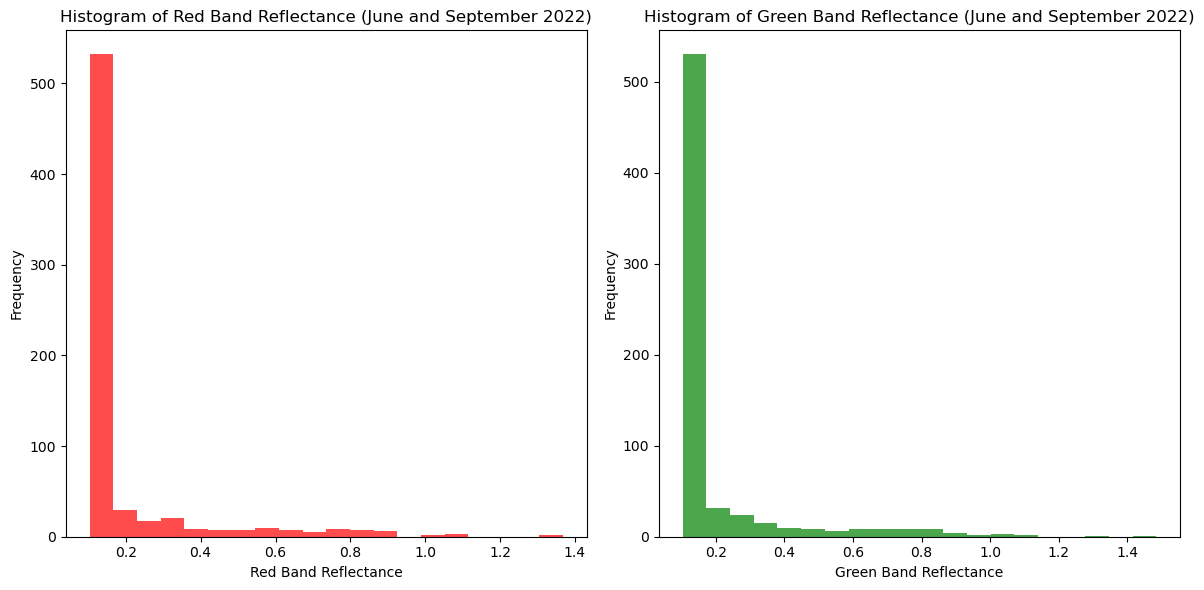

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime

# Filter the DataFrame to include only data from June and September 2022
start_date = datetime.strptime('2022-06-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2022-09-30', '%Y-%m-%d').date()
filtered_df = df_all_lakes[(df_all_lakes['DATE_SMP'] >= start_date) & (df_all_lakes['DATE_SMP'] <= end_date)]

# Plot histograms for the red and green bands
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(filtered_df['Red'], bins=20, color='red', alpha=0.7)
plt.xlabel('Red Band Reflectance')
plt.ylabel('Frequency')
plt.title('Histogram of Red Band Reflectance (June and September 2022)')

plt.subplot(1, 2, 2)
plt.hist(filtered_df['Green'], bins=20, color='green', alpha=0.7)
plt.xlabel('Green Band Reflectance')
plt.ylabel('Frequency')
plt.title('Histogram of Green Band Reflectance (June and September 2022)')

plt.tight_layout()
plt.show()


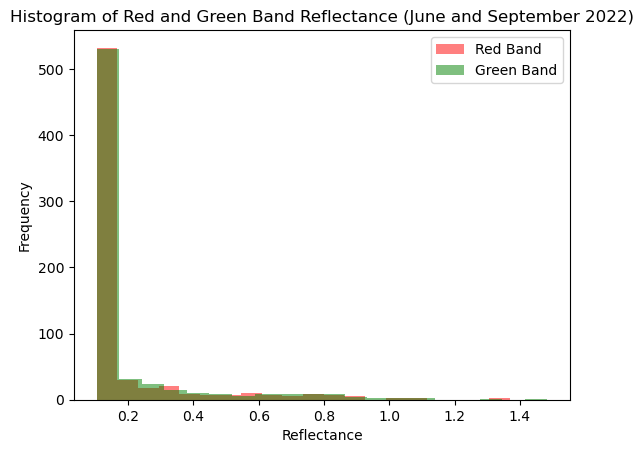

In [9]:
import matplotlib.pyplot as plt
from datetime import datetime

# Filter the DataFrame to include only data from June and September 2022
start_date = datetime.strptime('2022-06-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2022-09-30', '%Y-%m-%d').date()
filtered_df = df_all_lakes[(df_all_lakes['DATE_SMP'] >= start_date) & (df_all_lakes['DATE_SMP'] <= end_date)]

# Plot histograms for the red and green bands together
plt.hist(filtered_df['Red'], bins=20, color='red', alpha=0.5, label='Red Band')
plt.hist(filtered_df['Green'], bins=20, color='green', alpha=0.5, label='Green Band')

plt.xlabel('Reflectance')
plt.ylabel('Frequency')
plt.title('Histogram of Red and Green Band Reflectance (June and September 2022)')
plt.legend()

plt.show()


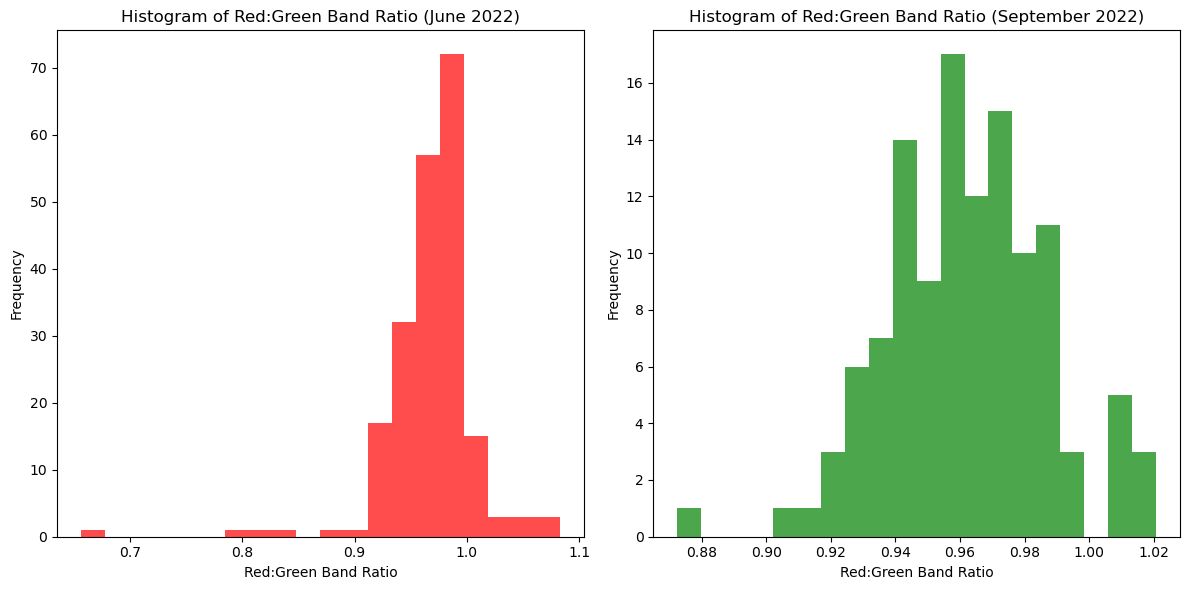

In [10]:
import matplotlib.pyplot as plt
from datetime import datetime

# Convert the 'DATE_SMP' column to datetime format
filtered_df['DATE_SMP'] = pd.to_datetime(filtered_df['DATE_SMP'])

# Calculate the red:green band ratio
filtered_df['red:green'] = filtered_df['Red'] / filtered_df['Green']

# Create subplots for histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(filtered_df[filtered_df['DATE_SMP'].dt.month == 6]['red:green'], bins=20, color='red', alpha=0.7)
plt.xlabel('Red:Green Band Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Red:Green Band Ratio (June 2022)')

plt.subplot(1, 2, 2)
plt.hist(filtered_df[filtered_df['DATE_SMP'].dt.month == 9]['red:green'], bins=20, color='green', alpha=0.7)
plt.xlabel('Red:Green Band Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Red:Green Band Ratio (September 2022)')

plt.tight_layout()
plt.show()


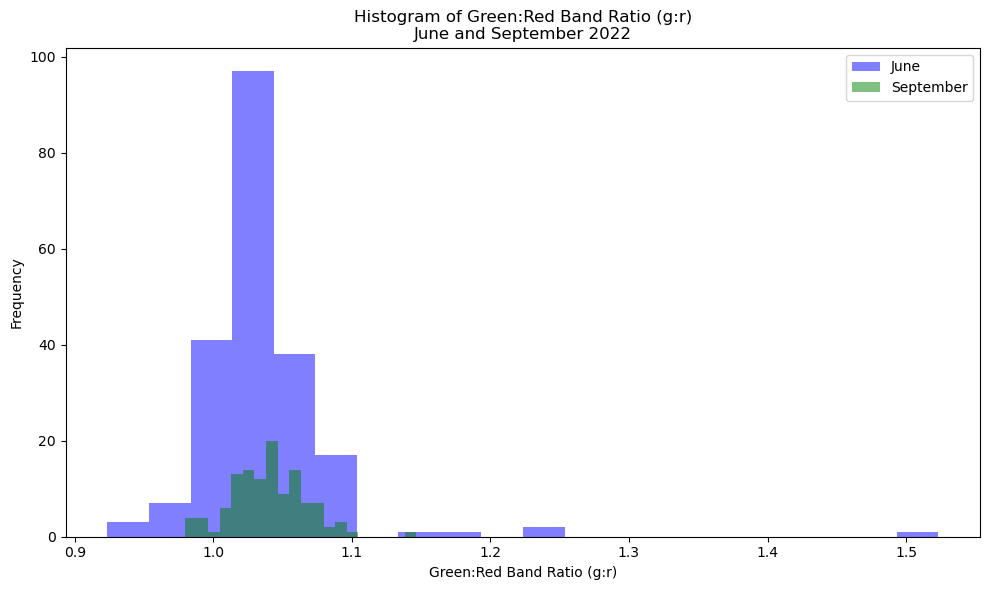

In [11]:
import matplotlib.pyplot as plt
from datetime import datetime

# Convert the 'DATE_SMP' column to datetime format
filtered_df['DATE_SMP'] = pd.to_datetime(filtered_df['DATE_SMP'])

# Calculate the green:red band ratio
filtered_df['g:r'] = filtered_df['Green'] / filtered_df['Red']

# Create a single histogram with different colors for June and September
plt.figure(figsize=(10, 6))

plt.hist(filtered_df[filtered_df['DATE_SMP'].dt.month == 6]['g:r'], bins=20, color='blue', alpha=0.5, label='June')
plt.hist(filtered_df[filtered_df['DATE_SMP'].dt.month == 9]['g:r'], bins=20, color='green', alpha=0.5, label='September')

plt.xlabel('Green:Red Band Ratio (g:r)')
plt.ylabel('Frequency')
plt.title('Histogram of Green:Red Band Ratio (g:r)\nJune and September 2022')
plt.legend()

plt.tight_layout()
plt.show()


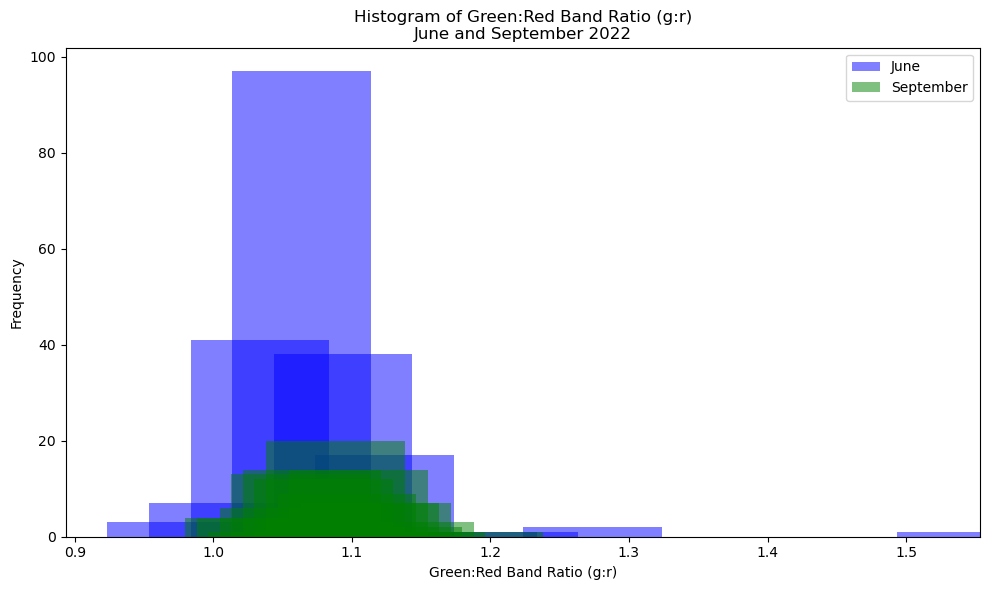

In [12]:
import matplotlib.pyplot as plt
from datetime import datetime

# Convert the 'DATE_SMP' column to datetime format
filtered_df['DATE_SMP'] = pd.to_datetime(filtered_df['DATE_SMP'])

# Calculate the green:red band ratio
filtered_df['g:r'] = filtered_df['Green'] / filtered_df['Red']

# Create a single histogram with different colors for June and September
plt.figure(figsize=(10, 6))

plt.hist(filtered_df[filtered_df['DATE_SMP'].dt.month == 6]['g:r'], bins=20, color='blue', alpha=0.5, label='June', width=0.1)
plt.hist(filtered_df[filtered_df['DATE_SMP'].dt.month == 9]['g:r'], bins=20, color='green', alpha=0.5, label='September', width=0.1)

plt.xlabel('Green:Red Band Ratio (g:r)')
plt.ylabel('Frequency')
plt.title('Histogram of Green:Red Band Ratio (g:r)\nJune and September 2022')
plt.legend()

plt.tight_layout()
plt.show()


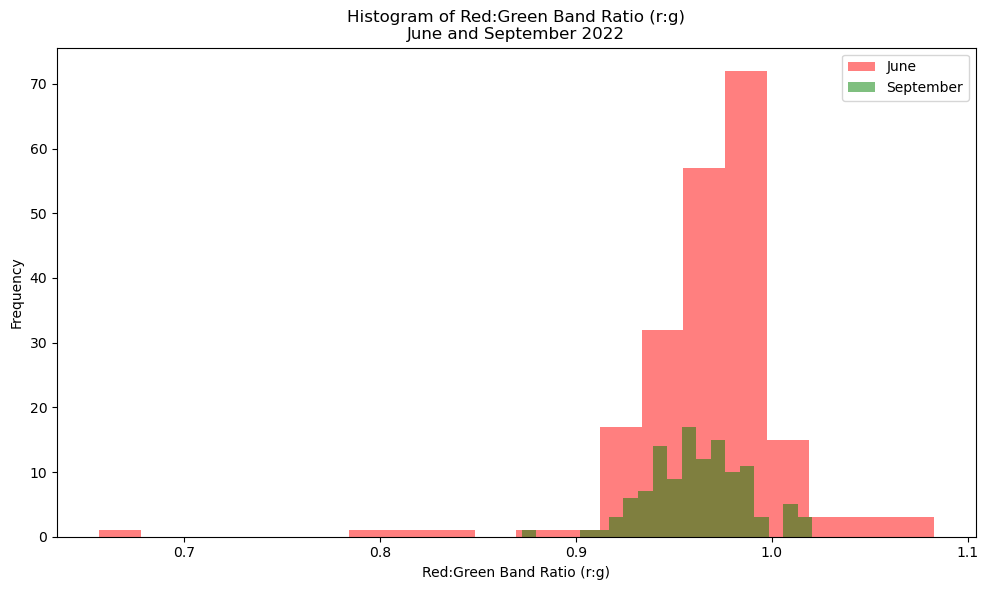

In [13]:
import matplotlib.pyplot as plt
from datetime import datetime

# Convert the 'DATE_SMP' column to datetime format
filtered_df['DATE_SMP'] = pd.to_datetime(filtered_df['DATE_SMP'])

# Calculate the red band ratio
filtered_df['r:g'] = filtered_df['Red'] / filtered_df['Green']

# Create a single histogram with different colors for June and September
plt.figure(figsize=(10, 6))

plt.hist(filtered_df[filtered_df['DATE_SMP'].dt.month == 6]['r:g'], bins=20, color='red', alpha=0.5, label='June')
plt.hist(filtered_df[filtered_df['DATE_SMP'].dt.month == 9]['r:g'], bins=20, color='green', alpha=0.5, label='September')

plt.xlabel('Red:Green Band Ratio (r:g)')
plt.ylabel('Frequency')
plt.title('Histogram of Red:Green Band Ratio (r:g)\nJune and September 2022')
plt.legend()

plt.tight_layout()
plt.show()


# 5 Highlighted Reflectance for [ RGB (Red, Green, Blue) ] Bands in July 2022

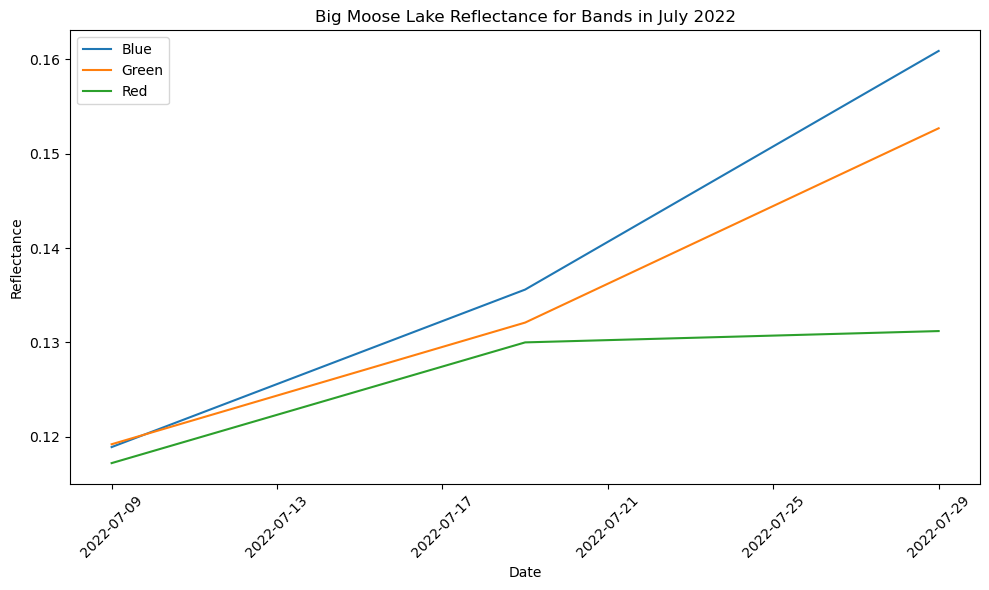

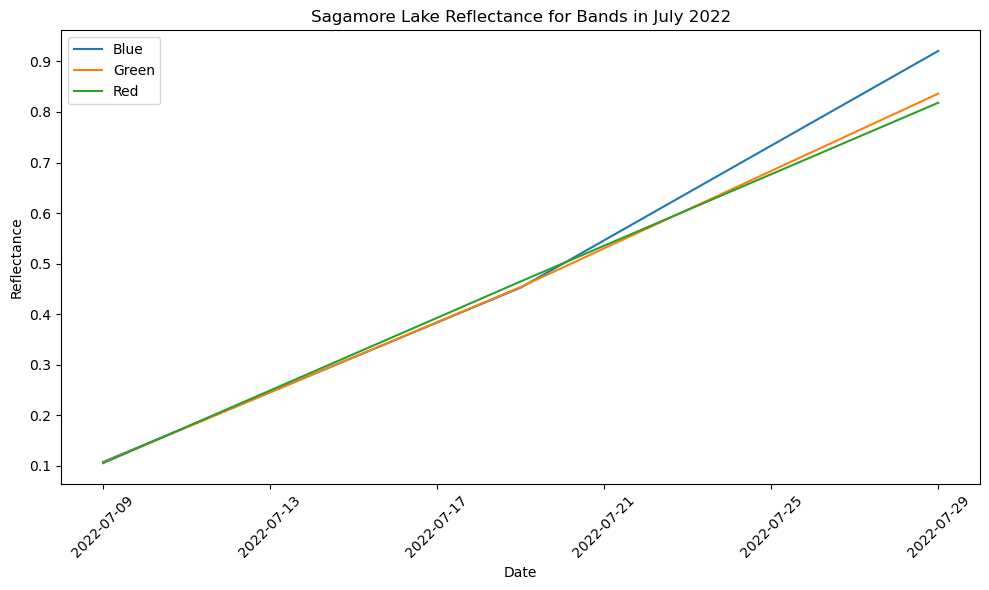

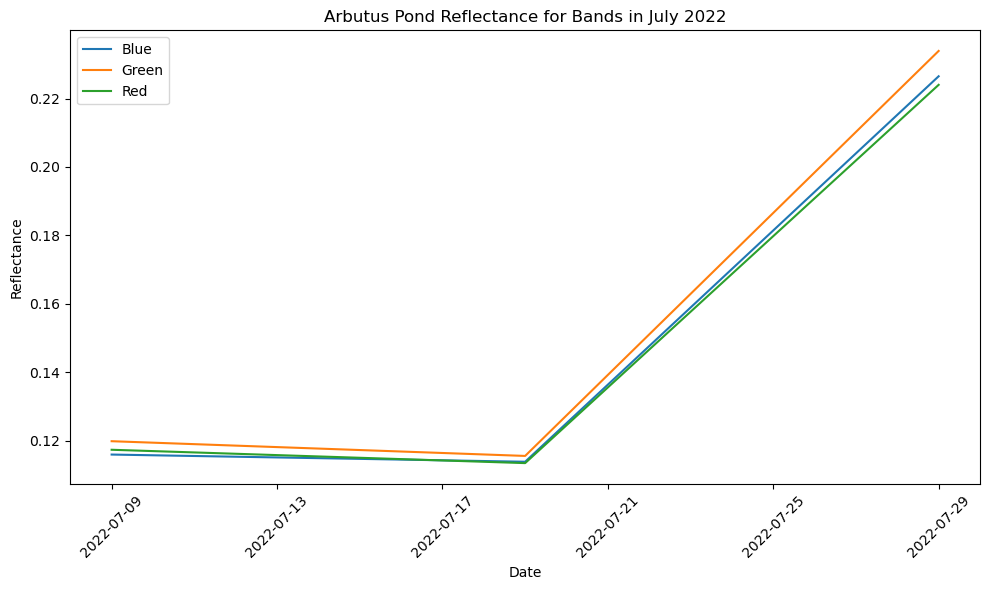

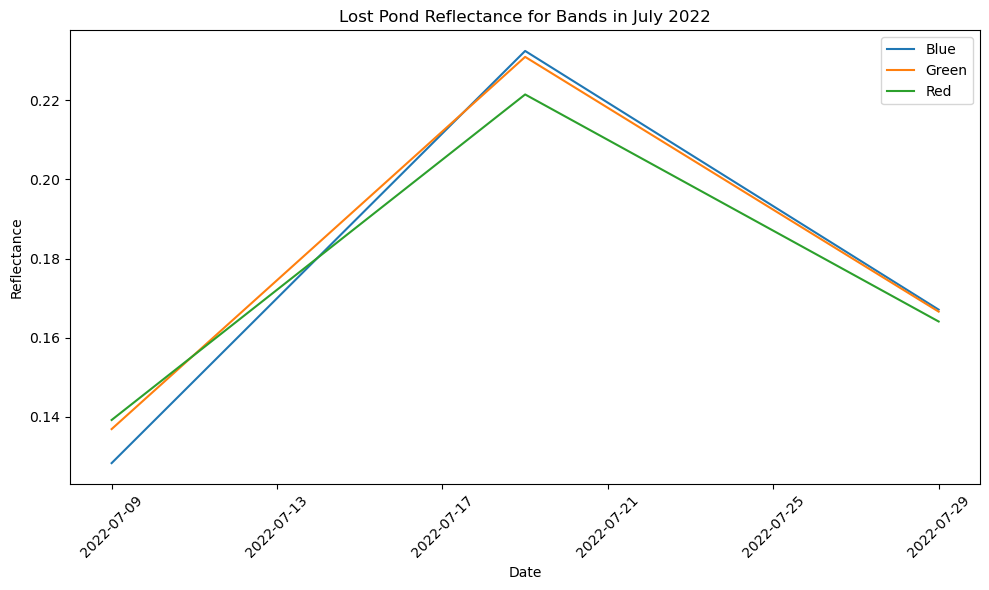

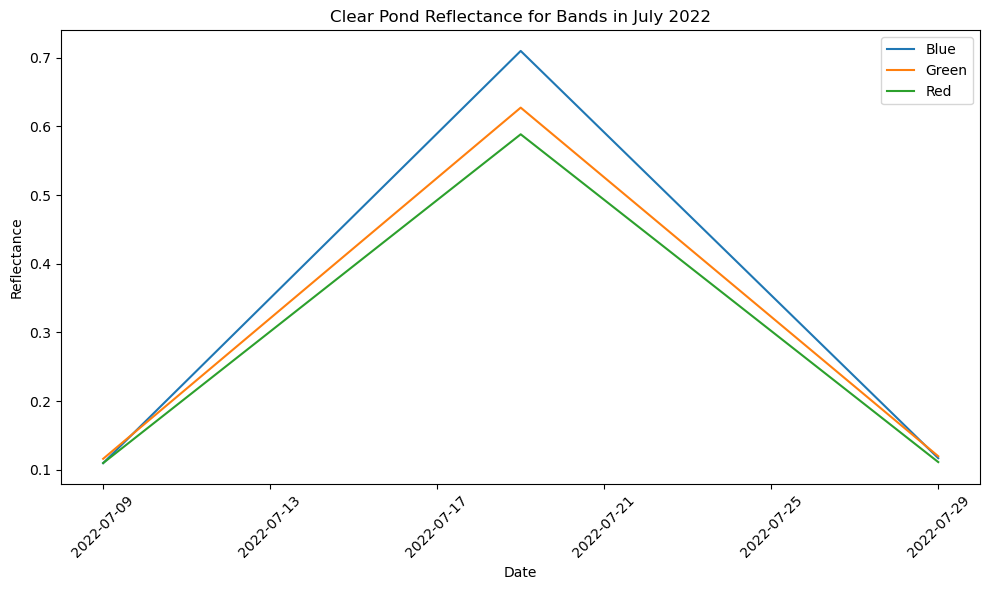

In [15]:
import matplotlib.pyplot as plt
from datetime import datetime

# Convert start_date and end_date to datetime.date objects
start_date = datetime.strptime('2022-07-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2022-07-31', '%Y-%m-%d').date()

# Filter the DataFrame to include only the highlighted lakes and the specified date range (July 2022)
highlighted_lakes = ['Big Moose Lake', 'Sagamore Lake', 'Arbutus Pond', 'Lost Pond', 'Clear Pond']

filtered_df = df_all_lakes[
    (df_all_lakes['SITE_NAME'].isin(highlighted_lakes)) &
    (df_all_lakes['DATE_SMP'].apply(lambda x: start_date <= x <= end_date))
]

# Select the columns corresponding to the bands you want to visualize
bands_to_plot = ['Blue', 'Green', 'Red']  # Modify this list based on your needs

# Plot the reflectance values for each band
for lake_name in highlighted_lakes:
    lake_df = filtered_df[filtered_df['SITE_NAME'] == lake_name]
    plt.figure(figsize=(10, 6))
    for band in bands_to_plot:
        plt.plot(lake_df['DATE_SMP'], lake_df[band], label=band)
    plt.title(f"{lake_name} Reflectance for Bands in July 2022")
    plt.xlabel('Date')
    plt.ylabel('Reflectance')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


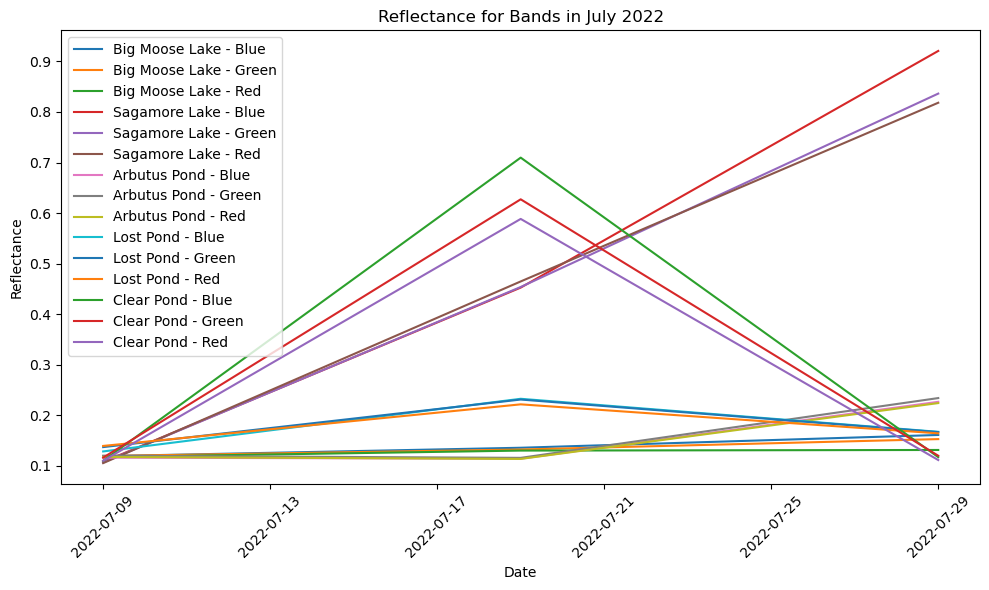

In [16]:
import matplotlib.pyplot as plt
from datetime import datetime, date

# Convert start_date and end_date to datetime.date objects
start_date = datetime.strptime('2022-07-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2022-07-31', '%Y-%m-%d').date()

# Filter the DataFrame to include only the highlighted lakes and the specified date range (July 2022)
highlighted_lakes = ['Big Moose Lake', 'Sagamore Lake', 'Arbutus Pond', 'Lost Pond', 'Clear Pond']

filtered_df = df_all_lakes[
    (df_all_lakes['SITE_NAME'].isin(highlighted_lakes)) &
    (df_all_lakes['DATE_SMP'].apply(lambda x: start_date <= x <= end_date))
]

# Select the columns corresponding to the bands you want to visualize
bands_to_plot = ['Blue', 'Green', 'Red']  # Modify this list based on your needs

# Plot the reflectance values for each band for all lakes in a single plot
plt.figure(figsize=(10, 6))

for lake_name in highlighted_lakes:
    lake_df = filtered_df[filtered_df['SITE_NAME'] == lake_name]
    for band in bands_to_plot:
        plt.plot(lake_df['DATE_SMP'], lake_df[band], label=f"{lake_name} - {band}")

plt.title("Reflectance for Bands in July 2022")
plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
import ee
import geemap
from datetime import datetime

# Authenticate and initialize the Earth Engine API
ee.Initialize()

# Define the list of lake names
highlighted_lakes = ['Big Moose Lake', 'Sagamore Lake', 'Arbutus Pond', 'Lost Pond', 'Clear Pond']

# Define the date range for July 2022
start_date = '2022-07-01'
end_date = '2022-07-31'

# Load the Sentinel-2 imagery collection
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(2022, 2022, 'year')) \
    .filterDate(start_date, end_date)

# Define the bands to select (B4, B3, B2)
bands_to_select = ['B4', 'B3', 'B2']

# Loop through each lake and generate and display the map
for lake_name in highlighted_lakes:
    # Get the lake's geometry
    lake_geometry = ee.FeatureCollection('projects/ee-touhedakhanom14/assets/stations-coord') \
        .filter(ee.Filter.eq('SITE_NAME', lake_name)) \
        .geometry()

    # Filter the imagery collection to the specific lake and bands
    lake_images = s2_collection \
        .filterBounds(lake_geometry) \
        .select(bands_to_select)

    # Create a mosaic of the images in the collection
    mosaic = lake_images.mosaic()

    # Create a visualization parameter dictionary
    vis_params = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 3000,
        'gamma': 1.4
    }

    # Create the map
    Map = geemap.Map()
    Map.centerObject(lake_geometry, 10)
    Map.addLayer(mosaic, vis_params, lake_name)
    
    # Display the map
    Map.addLayerControl()
    Map


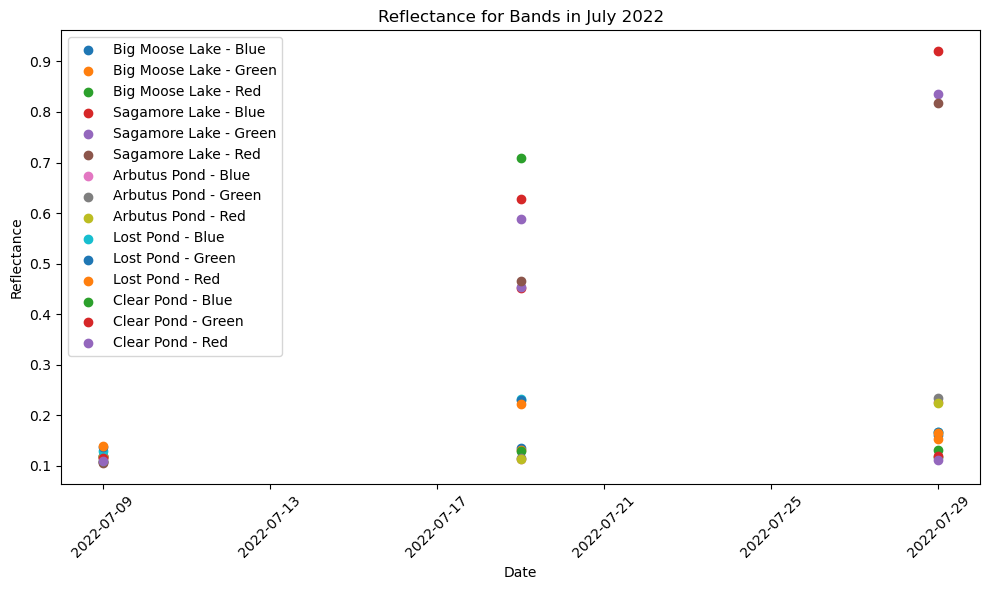

In [20]:
import matplotlib.pyplot as plt
from datetime import datetime

# Filter the DataFrame to include only the highlighted lakes and the specified date range (July 2022)
highlighted_lakes = ['Big Moose Lake', 'Sagamore Lake', 'Arbutus Pond', 'Lost Pond', 'Clear Pond']
start_date = '2022-07-01'
end_date = '2022-07-31'

# Convert start_date and end_date to datetime.date objects
start_date_obj = datetime.strptime(start_date, '%Y-%m-%d').date()
end_date_obj = datetime.strptime(end_date, '%Y-%m-%d').date()

filtered_df = df_all_lakes[
    (df_all_lakes['SITE_NAME'].isin(highlighted_lakes)) &
    (df_all_lakes['DATE_SMP'] >= start_date_obj) &
    (df_all_lakes['DATE_SMP'] <= end_date_obj)
]

# Select the columns corresponding to the bands you want to visualize
bands_to_plot = ['Blue', 'Green', 'Red']  # Modify this list based on your needs

# Plot the reflectance values for each band for all lakes with dots
plt.figure(figsize=(10, 6))

for lake_name in highlighted_lakes:
    lake_df = filtered_df[filtered_df['SITE_NAME'] == lake_name]
    for band in bands_to_plot:
        plt.scatter(lake_df['DATE_SMP'], lake_df[band], label=f"{lake_name} - {band}")

plt.title("Reflectance for Bands in July 2022")
plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


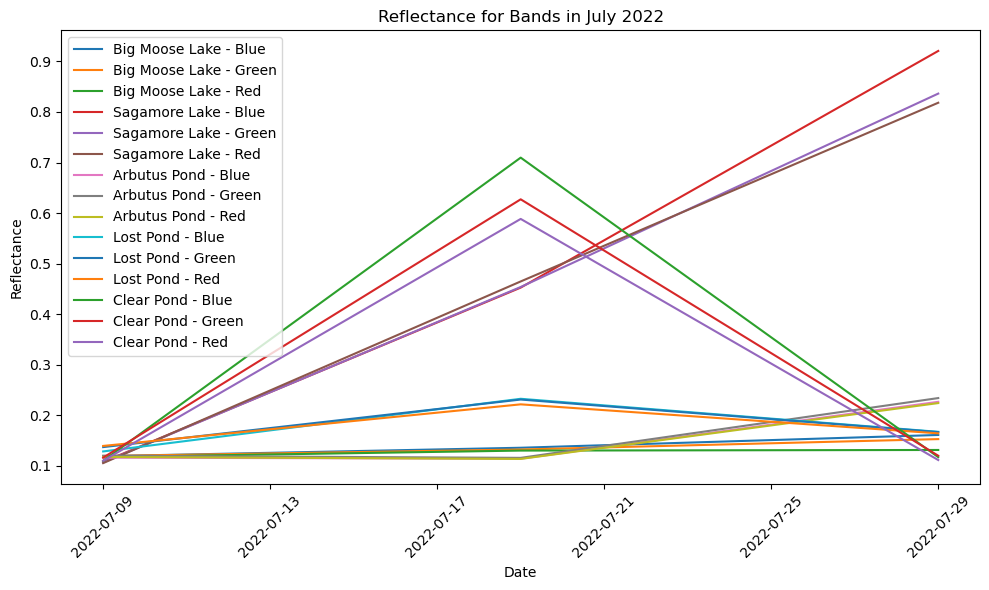

In [22]:
import matplotlib.pyplot as plt
from datetime import datetime

# Filter the DataFrame to include only the highlighted lakes and the specified date range (July 2022)
highlighted_lakes = ['Big Moose Lake', 'Sagamore Lake', 'Arbutus Pond', 'Lost Pond', 'Clear Pond']
start_date = '2022-07-01'
end_date = '2022-07-31'

# Convert start_date and end_date to datetime.date objects
start_date_obj = datetime.strptime(start_date, '%Y-%m-%d').date()
end_date_obj = datetime.strptime(end_date, '%Y-%m-%d').date()

filtered_df = df_all_lakes[
    (df_all_lakes['SITE_NAME'].isin(highlighted_lakes)) &
    (df_all_lakes['DATE_SMP'] >= start_date_obj) &
    (df_all_lakes['DATE_SMP'] <= end_date_obj)
]

# Select the columns corresponding to the bands you want to visualize
bands_to_plot = ['Blue', 'Green', 'Red']  # Modify this list based on your needs

# Plot the reflectance values for each band for all lakes with a line graph
plt.figure(figsize=(10, 6))

for lake_name in highlighted_lakes:
    lake_df = filtered_df[filtered_df['SITE_NAME'] == lake_name]
    for band in bands_to_plot:
        plt.plot(lake_df['DATE_SMP'], lake_df[band], label=f"{lake_name} - {band}")

plt.title("Reflectance for Bands in July 2022")
plt.xlabel('Date')
plt.ylabel('Reflectance')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
df_all_lakes

,DATE_SMP,Aerosols,Blue,Green,NIR,Red,RedEdge1,RedEdge2,RedEdge4,SWIR1,SITE_NAME
756,2019-01-04,0.8181,0.8262,0.7607,0.5595,0.6992,0.6896,0.6426,0.6591,0.0711,Loon Hollow Pond
5850,2019-01-04,0.8717,0.9142,0.9262,0.8625,0.9248,0.9573,0.9199,0.8928,0.0639,Barnes Lake
4841,2019-01-11,0.7205,0.7277,0.6671,0.5938,0.6506,0.6407,0.6310,0.6695,0.1581,Lake Rondaxe
6544,2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Lake (East Branch)
6081,2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clear Pond
...,...,...,...,...,...,...,...,...,...,...,...
2969,2023-07-19,0.7793,0.7946,0.7662,0.7770,0.7610,0.8050,0.7977,0.7859,0.6700,Avalanche Lake
968,2023-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loon Hollow Pond
6079,2023-07-22,0.1558,0.1596,0.1640,0.1660,0.1589,0.1660,0.1674,0.1557,0.1546,Barnes Lake
969,2023-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loon Hollow Pond


In [24]:
df_all_lakes.dropna(inplace=True)


In [25]:
df_all_lakes

,DATE_SMP,Aerosols,Blue,Green,NIR,Red,RedEdge1,RedEdge2,RedEdge4,SWIR1,SITE_NAME
756,2019-01-04,0.8181,0.8262,0.7607,0.5595,0.6992,0.6896,0.6426,0.6591,0.0711,Loon Hollow Pond
5850,2019-01-04,0.8717,0.9142,0.9262,0.8625,0.9248,0.9573,0.9199,0.8928,0.0639,Barnes Lake
4841,2019-01-11,0.7205,0.7277,0.6671,0.5938,0.6506,0.6407,0.6310,0.6695,0.1581,Lake Rondaxe
2857,2019-01-11,0.1862,0.1273,0.0863,0.0373,0.0550,0.0328,0.0622,0.0695,0.0049,Avalanche Lake
6319,2019-01-11,0.4772,0.8468,0.8359,0.8590,0.8563,0.9075,0.8903,0.9080,0.1668,Nate Pond
...,...,...,...,...,...,...,...,...,...,...,...
5613,2023-07-19,1.0965,1.0982,1.0580,1.0159,1.0544,1.1112,1.0667,1.0576,0.7273,Owen Pond
2413,2023-07-19,0.1237,0.1279,0.1313,0.1644,0.1358,0.1404,0.1473,0.1602,0.1759,North Lake
2969,2023-07-19,0.7793,0.7946,0.7662,0.7770,0.7610,0.8050,0.7977,0.7859,0.6700,Avalanche Lake
6079,2023-07-22,0.1558,0.1596,0.1640,0.1660,0.1589,0.1660,0.1674,0.1557,0.1546,Barnes Lake


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error




# Preparing the training data
X_train = merged_data[['blue', 'green', 'red', 'nir','LAKE_DEPTH_MEAN']]  # Features 
y_train = merged_data['DOC_MG_L']  # Target variable

# Split the dataset into training and testing sets where 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Train the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict DOC values for both training and testing data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)



# Create DataFrames for the training and testing data with all bands and the predicted values
data_train = pd.DataFrame(X_train, columns=['blue', 'green', 'red', 'nir','LAKE_DEPTH_MEAN'])

# data_train = pd.DataFrame(X_train, columns=['blue', 'green', 'red', 'nir,'LAKE_DEPTH_MEAN'])
data_train['original_DOC'] = y_train
data_train['predicted_DOC'] = y_pred_train

data_test = pd.DataFrame(X_test, columns=['blue', 'green', 'red', 'nir','LAKE_DEPTH_MEAN'])
data_test['original_DOC'] = y_test
data_test['predicted_DOC'] = y_pred_test


KeyError: "['blue', 'green', 'red', 'nir'] not in index"

In [ ]:
# Display the predicted DOC values for the training and testing data
print(f'*************Predicted Training data***************')
data_train

In [ ]:
print(f'*************Predicted Testing data***************')

data_test


In [ ]:
# Calculate the Mean Squared Error (MSE) for the testing data
mse_test = mean_squared_error(y_test, y_pred_test)

#MSE assesses the average squared difference between the observed and predicted values.

# Print the MSE for the testing data
print("Mean Squared Error (Testing):", mse_test)

# Mean Squared Error (Testing): 3.1830039718949323
#Mean Squared Error (Testing): 2.823120356864574
#Mean Squared Error (Testing): 5.634067462264807
